# AE 483: Final Project
### Search & Rescue with Variable Mass
#### Charlie Ray, Dennis McCann, Vivek Kodali, Michael Biela

# 1. Setup the Notebook

Import modules

In [79]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d

Define a function to load data from hardware. 

#### This function was created by Professor Bretl ####

In [80]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        if 'ae483log.o_z_des' not in resampled_data.keys():
            raise Exception('"ae483log.o_z_des" must be logged')
        i = np.argwhere(resampled_data['ae483log.o_z_des'] > 0).flatten()
        if len(i) == 0:
            raise Exception('o_z_des was never positive')
        if len(i) < 2:
            raise Exception('o_z_des was only positive for one time step')
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

In [81]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')

In [82]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')

In [83]:
def resample(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

# 2. Derive Models

## 2.1. Symbolic Variables

Define States:

In [84]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

n_x, n_y, r = sym.symbols('n_x, n_y, r')

# x, y, and z positions of loco anchors plus distances from anchors to tag
x0, y0, z0, d0 = sym.symbols('x0, y0, z0, d0')
x1, y1, z1, d1 = sym.symbols('x1, y1, z1, d1')
x2, y2, z2, d2 = sym.symbols('x2, y2, z2, d2')
x3, y3, z3, d3 = sym.symbols('x3, y3, z3, d3')
x4, y4, z4, d4 = sym.symbols('x4, y4, z4, d4')
x5, y5, z5, d5 = sym.symbols('x5, y5, z5, d5')
x6, y6, z6, d6 = sym.symbols('x6, y6, z6, d6')
x7, y7, z7, d7 = sym.symbols('x7, y7, z7, d7')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m, J_x, J_y, J_z, g = sym.symbols('m, J_x, J_y, J_z, g')



k_flow = sym.symbols('k_flow')

Create linear and angular velocity vectors (in coordinates of the body frame)

In [85]:
v_01in1 = sym.Matrix([[v_x], [v_y], [v_z]])
w_01in1 = sym.Matrix([[w_x], [w_y], [w_z]])

Create a moment of inertia matrix (in coordinates of the body frame)

In [86]:
J_in1 = sym.diag(J_x, J_y, J_z)
s_with_des = [o_x, o_y, o_z]

## 2.2. Controller

### 2.2.1. Rotation Matrix in terms of Yaw, Pitch, and Roll Angles

Define individual rotation matrices

In [87]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone

In [88]:
R_1in0 = Rz * Ry * Rx

### 2.2.2. Map from Angular Velocities to Angular Rates

This can be done using the following equation:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

In [89]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))
        
N = sym.simplify(Ninv.inv())

### 2.2.3. Define Equations of Motion

Forces:

In [90]:
f_in1 = R_1in0.T * sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# f_z_over_m = a_z + (w_01in1.cross(v_01in1))[2]

Torques:

In [91]:
tau_in1 = sym.Matrix([[tau_x], [tau_y], [tau_z]])

Equations of Motion:

In [92]:
f_sym_con = sym.Matrix.vstack(
    R_1in0 * v_01in1,
    N * w_01in1,
    (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1)),
    J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)))

These Equations of Motion have the following form:

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ \omega_x \\ \omega_y \\ \omega_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
\qquad\qquad
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \end{bmatrix}.
$$

In [93]:
f_sym_con

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                (g*m*sin(theta) + m*v_y*w_z - m*v_z*w_y)/m

## 2.4. State-Space Model

Define constants

In [94]:
# Mass
m_val = 0.04275    # <-- FIXME

# Principle moments of inertia
J_x_val = 0.00002079685  # <-- FIXME
J_y_val = 0.00002122075  # <-- FIXME
J_z_val = 0.000030112233  # <-- FIXME

# Acceleration of gravity
g_val = 9.81

# k_flow value
k_flow_val = 0.01 * 30.0 / np.deg2rad(4.2)

# Anchor Positions
x0_val = -1.50
y0_val = -1.60
z0_val = 0.33

x1_val = -1.45
y1_val = 1.78
z1_val = 1.87

x2_val = 1.83
y2_val = 1.78
z2_val = 0.34

x3_val = 1.78
y3_val = -1.59
z3_val = 1.88

x4_val = -1.52
y4_val = -1.57
z4_val = 1.88

x5_val = -1.52
y5_val = 1.79
z5_val = 0.33

x6_val = 1.87
y6_val = 1.79
z6_val = 1.85

x7_val = 1.82
y7_val = -1.59
z7_val = 0.32


Create a list of states, inputs, and parameters as symbolic variables.

In [95]:
s_con = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
i_con = [tau_x, tau_y, tau_z, f_z]
p_con = [m, J_x, J_y, J_z, g]

s_with_des = [o_x, o_y, o_z]  # <-- states whose desired values will be 
                              #     specified by our client

In [96]:
f_con = sym.lambdify(s_con + i_con + p_con, f_sym_con)

# f_sym.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

equilibrum arrays for parameters

In [97]:
s_eq_con = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] # <-- FIXME
i_eq_con = [0., 0., 0., m_val*g_val]                    # <-- FIXME
p_eq_con = [m_val, J_x_val, J_y_val, J_z_val, g_val]

In [98]:
i_eq_con

[0.0, 0.0, 0.0, 0.41937750000000007]

In [99]:
print(f_con(*s_eq_con, *i_eq_con, *p_eq_con))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## 2.5. Compute A and B for the CONTROLLER

In [100]:
# # Find A, B, C, D OLD
# A_old = f_sym.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
# B_old = f_sym.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
# C_old = h.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
# D_old = h.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

# New A, B, C, and D 
A_sym_con = f_sym_con.jacobian(s_con).subs(tuple(zip(s_con, s_eq_con))).subs(tuple(zip(i_con, i_eq_con)))
B_sym_con = f_sym_con.jacobian(i_con).subs(tuple(zip(s_con, s_eq_con))).subs(tuple(zip(i_con, i_eq_con)))

In [101]:
A_num = sym.lambdify(s_con + i_con + p_con, A_sym_con)
A = A_num(*s_eq_con, *i_eq_con, *p_eq_con)

In [102]:
B_num = sym.lambdify(s_con + i_con + p_con, B_sym_con)
B = B_num(*s_eq_con, *i_eq_con, *p_eq_con)

In [103]:
A_sym_con

Matrix([
[0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, g,  0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -g, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0]])

In [104]:
B_sym_con

Matrix([
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0,   0],
[    0,     0,     0, 1/m],
[1/J_x,     0,     0,   0],
[    0, 1/J_y,     0,   0],
[    0,     0, 1/J_z,   0]])

## 2.6. Observer

Up until now, everything we have done has been exactly the same as was done in class (in fact, all of the code has been copied from the lab 7 jupyter notebook). Here, however, is where we begin to deviate.

Below is an array of the measurement equations we used in lab, concatenated with the new measurement equations that result from the loco positioning system. 

In [105]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [106]:
h = sym.Matrix([
    k_flow * (v_x - o_z * w_y) / o_z,        # <-- x flow (n_x)
    k_flow * (v_y + o_z * w_x) / o_z,        # <-- y flow (n_y)
    o_z / (sym.cos(phi) * sym.cos(theta)),   # <-- z range (r)
    ((o_x - x0)**2 + (o_y - y0)**2 + (o_z - z0)**2)**(1/2),   # < -- distance from anchor 0 (d0)
    ((o_x - x1)**2 + (o_y - y1)**2 + (o_z - z1)**2)**(1/2),   # < -- distance from anchor 1 (d1)
    ((o_x - x2)**2 + (o_y - y2)**2 + (o_z - z2)**2)**(1/2),   # < -- distance from anchor 2 (d2)
    ((o_x - x3)**2 + (o_y - y3)**2 + (o_z - z3)**2)**(1/2),   # < -- distance from anchor 3 (d3)
    ((o_x - x4)**2 + (o_y - y4)**2 + (o_z - z4)**2)**(1/2),   # < -- distance from anchor 4 (d4)
    ((o_x - x5)**2 + (o_y - y5)**2 + (o_z - z5)**2)**(1/2),   # < -- distance from anchor 5 (d5)
    ((o_x - x6)**2 + (o_y - y6)**2 + (o_z - z6)**2)**(1/2),   # < -- distance from anchor 6 (d6)
    ((o_x - x7)**2 + (o_y - y7)**2 + (o_z - z7)**2)**(1/2)    # < -- distance from anchor 7 (d7)
])


In [107]:
h

Matrix([
[                         k_flow*(-o_z*w_y + v_x)/o_z],
[                          k_flow*(o_z*w_x + v_y)/o_z],
[                           o_z/(cos(phi)*cos(theta))],
[((o_x - x0)**2 + (o_y - y0)**2 + (o_z - z0)**2)**0.5],
[((o_x - x1)**2 + (o_y - y1)**2 + (o_z - z1)**2)**0.5],
[((o_x - x2)**2 + (o_y - y2)**2 + (o_z - z2)**2)**0.5],
[((o_x - x3)**2 + (o_y - y3)**2 + (o_z - z3)**2)**0.5],
[((o_x - x4)**2 + (o_y - y4)**2 + (o_z - z4)**2)**0.5],
[((o_x - x5)**2 + (o_y - y5)**2 + (o_z - z5)**2)**0.5],
[((o_x - x6)**2 + (o_y - y6)**2 + (o_z - z6)**2)**0.5],
[((o_x - x7)**2 + (o_y - y7)**2 + (o_z - z7)**2)**0.5]])

new f for observer:

In [108]:
f_z_over_m = a_z + (w_01in1.cross(v_01in1))[2]

f_in1_over_m = R_1in0.T * sym.Matrix([[0], [0], [-g]]) + sym.Matrix([[0], [0], [f_z_over_m]])

f_obs = sym.Matrix.vstack(R_1in0 * v_01in1,
                          N * w_01in1,
                          (f_in1_over_m - w_01in1.cross(v_01in1)),
)


These measurement equations have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} n_x \\ n_y \\ r \\ d_0 \\ d_1 \\ d_2 \\ d_3 \\ ... \\ d_7 \end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

In [109]:
# o_x_eq, o_y_eq, o_z_eq = sym.symbols('o_x_eq, o_y_eq, o_z_eq')
o_x_eq = 0.
o_y_eq = 0.
o_z_eq = 0.5

In [110]:
# Old state, input, output and parameters
s_obs = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z]
i_obs = [w_x, w_y, w_z, a_z]
o_obs = [n_x, n_y, r, d0, d1, d2, d3, d4, d5, d6, d7]
p_obs = [g, k_flow, 
         x0, y0, z0,
         x1, y1, z1,
         x2, y2, z2,
         x3, y3, z3,
         x4, y4, z4,
         x5, y5, z5,
         x6, y6, z6,
         x7, y7, z7]

In [111]:
# New state and input equilibrium lists
s_eq_obs = [o_x_eq, o_y_eq, o_z_eq, 0, 0, 0, 0, 0, 0]
i_eq_obs = [0, 0, 0, g_val]
p_eq_obs = [g_val, k_flow_val,
            x0_val, y0_val, z0_val,
            x1_val, y1_val, z1_val,
            x2_val, y2_val, z2_val,
            x3_val, y3_val, z3_val,
            x4_val, y4_val, z4_val,
            x5_val, y5_val, z5_val,
            x6_val, y6_val, z6_val,
            x7_val, y7_val, z7_val]

In [112]:
# Make sure all values are symbolic
s_eq_obs = [sym.nsimplify(a) for a in s_eq_obs]
i_eq_obs = [sym.nsimplify(a) for a in i_eq_obs]
p_eq_obs = [sym.nsimplify(a) for a in p_eq_obs]

In [113]:
f_obs.subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))

Matrix([
[          0],
[          0],
[          0],
[          0],
[          0],
[          0],
[          0],
[          0],
[981/100 - g]])

## 2.7. Compute A, B, C, and D for the OBSERVER

In [114]:
A_obs_sym = f_obs.jacobian(s_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))
B_obs_sym = f_obs.jacobian(i_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))
C_obs_sym = h.jacobian(s_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))
D_obs_sym = h.jacobian(i_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))

In [115]:
A_obs_sym

Matrix([
[0, 0, 0, 0, 0,  0, 1, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, g,  0, 0, 0, 0],
[0, 0, 0, 0, 0, -g, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0]])

In [116]:
B_obs_sym

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 1]])

In [117]:
C_obs_sym

Matrix([
[                                           0,                                            0,                                                   0, 0, 0, 0, 2*k_flow,        0, 0],
[                                           0,                                            0,                                                   0, 0, 0, 0,        0, 2*k_flow, 0],
[                                           0,                                            0,                                                   1, 0, 0, 0,        0,        0, 0],
[-1.0*x0/(x0**2 + y0**2 + (1/2 - z0)**2)**0.5, -1.0*y0/(x0**2 + y0**2 + (1/2 - z0)**2)**0.5, (0.5 - 1.0*z0)/(x0**2 + y0**2 + (1/2 - z0)**2)**0.5, 0, 0, 0,        0,        0, 0],
[-1.0*x1/(x1**2 + y1**2 + (1/2 - z1)**2)**0.5, -1.0*y1/(x1**2 + y1**2 + (1/2 - z1)**2)**0.5, (0.5 - 1.0*z1)/(x1**2 + y1**2 + (1/2 - z1)**2)**0.5, 0, 0, 0,        0,        0, 0],
[-1.0*x2/(x2**2 + y2**2 + (1/2 - z2)**2)**0.5, -1.0*y2/(x2**2 + y2**2 + (1/2 - z2)**2)**0.5, (0.

In [118]:
D_obs_sym

Matrix([
[     0, -k_flow, 0, 0],
[k_flow,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0]])

In [119]:
x_obs = sym.Matrix(s_obs) - sym.Matrix(s_eq_obs)
u_obs = sym.Matrix(i_obs) - sym.Matrix(i_eq_obs)
y_obs = sym.Matrix(o_obs) - h.subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))

In [120]:
A_obs_sym * x_obs + B_obs_sym * u_obs

Matrix([
[          v_x],
[          v_y],
[          v_z],
[          w_z],
[          w_y],
[          w_x],
[      g*theta],
[       -g*phi],
[a_z - 981/100]])

In [121]:
C_obs_sym * x_obs + D_obs_sym * u_obs

Matrix([
[                                                                                                                                           2*k_flow*v_x - k_flow*w_y],
[                                                                                                                                           2*k_flow*v_y + k_flow*w_x],
[                                                                                                                                                           o_z - 1/2],
[-1.0*o_x*x0/(x0**2 + y0**2 + (1/2 - z0)**2)**0.5 - 1.0*o_y*y0/(x0**2 + y0**2 + (1/2 - z0)**2)**0.5 + (0.5 - 1.0*z0)*(o_z - 1/2)/(x0**2 + y0**2 + (1/2 - z0)**2)**0.5],
[-1.0*o_x*x1/(x1**2 + y1**2 + (1/2 - z1)**2)**0.5 - 1.0*o_y*y1/(x1**2 + y1**2 + (1/2 - z1)**2)**0.5 + (0.5 - 1.0*z1)*(o_z - 1/2)/(x1**2 + y1**2 + (1/2 - z1)**2)**0.5],
[-1.0*o_x*x2/(x2**2 + y2**2 + (1/2 - z2)**2)**0.5 - 1.0*o_y*y2/(x2**2 + y2**2 + (1/2 - z2)**2)**0.5 + (0.5 - 1.0*z2)*(o_z - 1/2)/(x2**2 + y2**2 + (1/2 

lambdify A - D arrays

In [205]:
A_obs_num = sym.lambdify(s_obs + i_obs + p_obs, A_obs_sym)
B_obs_num = sym.lambdify(s_obs + i_obs + p_obs, B_obs_sym)
C_obs_num = sym.lambdify(s_obs + i_obs + p_obs, C_obs_sym)
D_obs_num = sym.lambdify(s_obs + i_obs + p_obs, D_obs_sym)

A_obs = A_obs_num(*s_eq_obs, *i_eq_obs, *p_eq_obs)
B_obs = B_obs_num(*s_eq_obs, *i_eq_obs, *p_eq_obs)
C_obs = C_obs_num(*s_eq_obs, *i_eq_obs, *p_eq_obs)
D_obs = D_obs_num(*s_eq_obs, *i_eq_obs, *p_eq_obs)



In [201]:
A_obs

array([[0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 981/100, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, -981/100, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [202]:
B_obs

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

In [203]:
C_obs

array([[0, 0, 0, 0, 0, 0, 102313891987647/12500000000000, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 102313891987647/12500000000000, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0.681895674366232, 0.727355385990648, 0.0772815097615063, 0, 0,
        0, 0, 0, 0],
       [0.542352699501114, -0.665784693180678, -0.512429791942432, 0, 0,
        0, 0, 0, 0],
       [-0.715428024827035, -0.695880811033947, 0.0625510841378828, 0, 0,
        0, 0, 0, 0],
       [-0.645635635303831, 0.576719471984883, -0.500548975684993, 0, 0,
        0, 0, 0, 0],
       [0.588118863136118, 0.607464878370859, -0.533950020478844, 0, 0,
        0, 0, 0, 0],
       [0.645588044517566, -0.760264868214765, 0.0722039260315698, 0, 0,
        0, 0, 0, 0],
       [-0.640519895012334, -0.613117974370095, -0.462407410837781, 0, 0,
        0, 0, 0, 0],
       [-0.751008902140546, 0.656101183738170, 0.0742756057062079, 0, 0,
        0, 0, 0, 0]], dtype=object)

In [204]:
D_obs

array([[0, -102313891987647/25000000000000, 0, 0],
       [102313891987647/25000000000000, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=object)

# 3. STD tests for observer

In [127]:
data = load_hardware_data(
    'variance_data.json',  # <-- replace with name of file with hardware data
    t_min_offset=3.,       # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=3.,       # <-- (optional) replace with how many seconds of data to ignore at end
    only_in_flight=True,   # <-- (optional) only loads data for which o_z_des is positive
)

# time
t = data['time']

# states
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']
v_x = data['ae483log.v_x']
v_y = data['ae483log.v_y']
v_z = data['ae483log.v_z']

# inputs
w_x = data['ae483log.w_x']
w_y = data['ae483log.w_y']
w_z = data['ae483log.w_z']
a_z = data['ae483log.a_z']

# outputs
n_x = data['ae483log.n_x']
n_y = data['ae483log.n_y']
r = data['ae483log.r']

# loco distances
d0 = data['ae483log.d0']
d1 = data['ae483log.d1']
d2 = data['ae483log.d2']
d3 = data['ae483log.d3']
d4 = data['ae483log.d4']
d5 = data['ae483log.d5']
d6 = data['ae483log.d6']
d7 = data['ae483log.d7']

dt = t[1] - t[0]
print(f'dt = {dt:.4f}')

# Optical flow constant (do not modify)
k_flow_val = 0.01 * 30.0 / np.deg2rad(4.2)

# Equilibrium value of o_z
o_z_eq_val = 0.5 # <-- FIXME

dt = 0.0100


## 4.2 Error in linearized equations of motion

### 4.2.1 Error in linear model of $\dot{o}_x$

Approximate $\dot{o}_x$ by finite difference and call this "ground truth."

In [128]:
o_x_dot_true = (o_x[1:] - o_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_x_dot_true` is one less than the length of `o_x` (and of `t`):

In [129]:
print(f'len(o_x_dot_true) = {len(o_x_dot_true)}')
print(f'         len(o_x) = {len(o_x)}')
print(f'           len(t) = {len(t)}')

len(o_x_dot_true) = 1278
         len(o_x) = 1279
           len(t) = 1279


Predict $\dot{o}_x$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_x$, and that the first element of $Ax+Bu$ is $v_x$. So, our state-space model tells us that $\dot{o}_x \approx v_x$.

In [130]:
o_x_dot_predicted = v_x

Compare the true value and the predicted values of $\dot{o}_x$ in a plot.

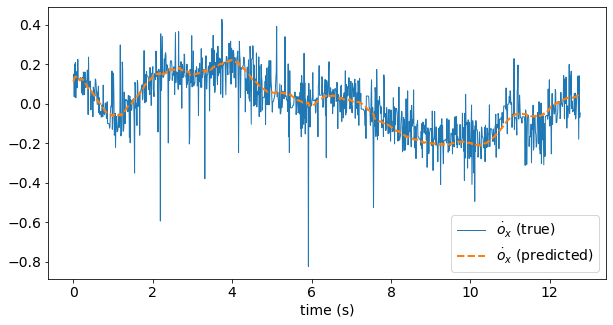

In [131]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_x_dot_true, label='$\dot{o}_x$ (true)', linewidth=1)
plt.plot(t, o_x_dot_predicted, '--', label='$\dot{o}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_x$.

In [132]:
o_x_dot_err = o_x_dot_predicted[:-1] - o_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

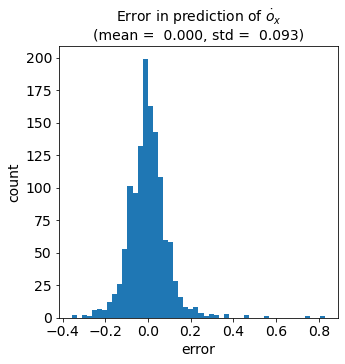

In [133]:
plt.figure(figsize=(5, 5))
plt.hist(o_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

o_x_std = np.std(o_x_dot_err)

plt.title(
    'Error in prediction of $\dot{o}_x$\n' +
    f'(mean = {np.mean(o_x_dot_err):6.3f}, std = {o_x_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.2 Error in linear model of $\dot{o}_y$

len(o_y_dot_true) = 1278
         len(o_y) = 1279
           len(t) = 1279


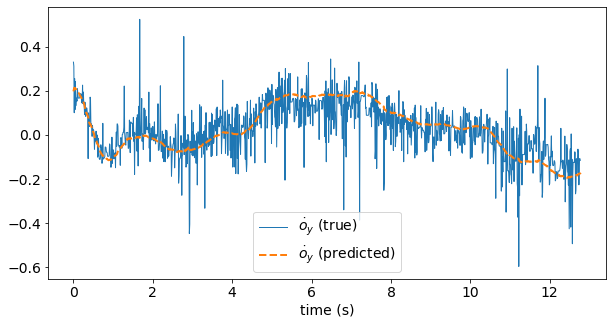

In [134]:
o_y_dot_true = (o_y[1:] - o_y[:-1]) / dt

print(f'len(o_y_dot_true) = {len(o_y_dot_true)}')
print(f'         len(o_y) = {len(o_y)}')
print(f'           len(t) = {len(t)}')

o_y_dot_predicted = v_y

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_y_dot_true, label='$\dot{o}_y$ (true)', linewidth=1)
plt.plot(t, o_y_dot_predicted, '--', label='$\dot{o}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

o_y_dot_err = o_y_dot_predicted[:-1] - o_y_dot_true

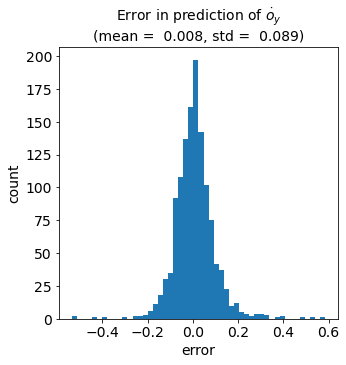

In [135]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(o_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

o_y_std = np.std(o_y_dot_err)

plt.title(
    'Error in prediction of $\dot{o}_y$\n' +
    f'(mean = {np.mean(o_y_dot_err):6.3f}, std = {o_y_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.3 Error in linear model of $\dot{o}_z$

len(o_z_dot_true) = 1278
         len(o_z) = 1279
           len(t) = 1279


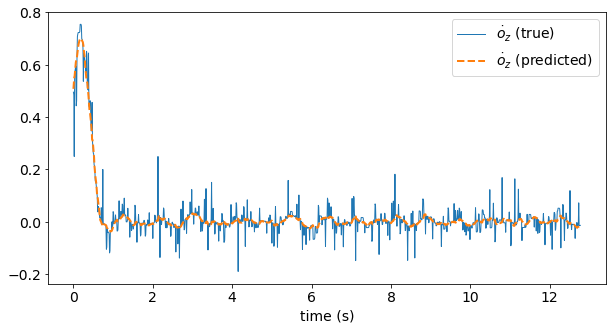

In [136]:
o_z_dot_true = (o_z[1:] - o_z[:-1]) / dt

print(f'len(o_z_dot_true) = {len(o_z_dot_true)}')
print(f'         len(o_z) = {len(o_z)}')
print(f'           len(t) = {len(t)}')

o_z_dot_predicted = v_z

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_z_dot_true, label='$\dot{o}_z$ (true)', linewidth=1)
plt.plot(t, o_z_dot_predicted, '--', label='$\dot{o}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

o_z_dot_err = o_z_dot_predicted[:-1] - o_z_dot_true

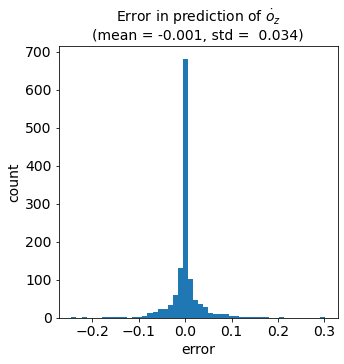

In [137]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(o_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

o_z_std = np.std(o_z_dot_err)

plt.title(
    'Error in prediction of $\dot{o}_z$\n' +
    f'(mean = {np.mean(o_z_dot_err):6.3f}, std = {o_z_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.4 Error in linear model of $\dot{\psi}$

len(psi_dot_true) = 1278
         len(psi) = 1279
           len(t) = 1279


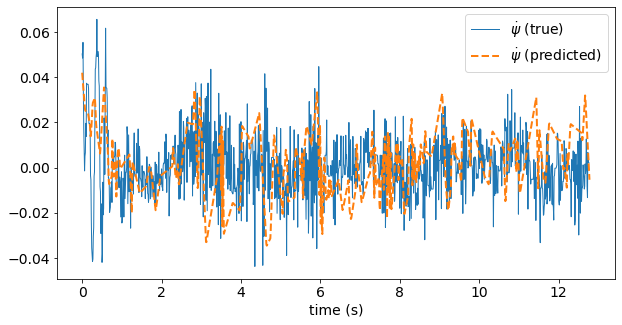

In [138]:
psi_dot_true = (psi[1:] - psi[:-1]) / dt

print(f'len(psi_dot_true) = {len(psi_dot_true)}')
print(f'         len(psi) = {len(psi)}')
print(f'           len(t) = {len(t)}')

psi_dot_predicted = w_z

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], psi_dot_true, label='$\dot{\psi}$ (true)', linewidth=1)
plt.plot(t, psi_dot_predicted, '--', label='$\dot{\psi}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

psi_dot_err = psi_dot_predicted[:-1] - psi_dot_true

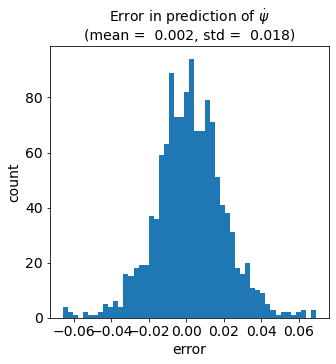

In [139]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(psi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

psi_std = np.std(psi_dot_err)

plt.title(
    'Error in prediction of $\dot{\psi}$\n' +
    f'(mean = {np.mean(psi_dot_err):6.3f}, std = {psi_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.5 Error in linear model of $\dot{\theta}$

len(theta_dot_true) = 1278
         len(theta) = 1279
           len(t) = 1279


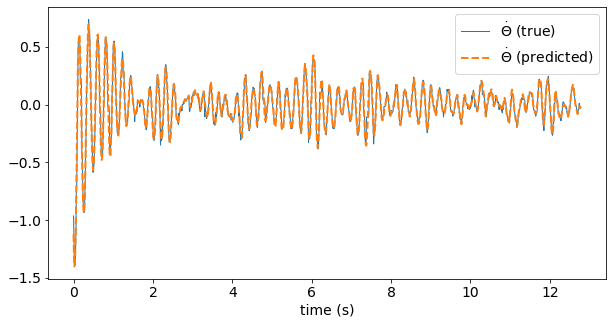

In [140]:
theta_dot_true = (theta[1:] - theta[:-1]) / dt

print(f'len(theta_dot_true) = {len(theta_dot_true)}')
print(f'         len(theta) = {len(theta)}')
print(f'           len(t) = {len(t)}')

theta_dot_predicted = w_y

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], theta_dot_true, label='$\dot{\Theta}$ (true)', linewidth=1)
plt.plot(t, theta_dot_predicted, '--', label='$\dot{\Theta}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

theta_dot_err = theta_dot_predicted[:-1] - theta_dot_true

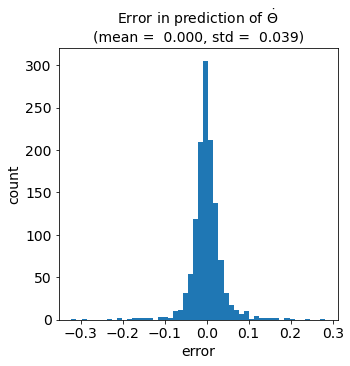

In [141]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(theta_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

theta_std = np.std(theta_dot_err)

plt.title(
    'Error in prediction of $\dot{\Theta}$\n' +
    f'(mean = {np.mean(theta_dot_err):6.3f}, std = {theta_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.6 Error in linear model of $\dot{\phi}$

len(phi_dot_true) = 1278
         len(phi) = 1279
           len(t) = 1279


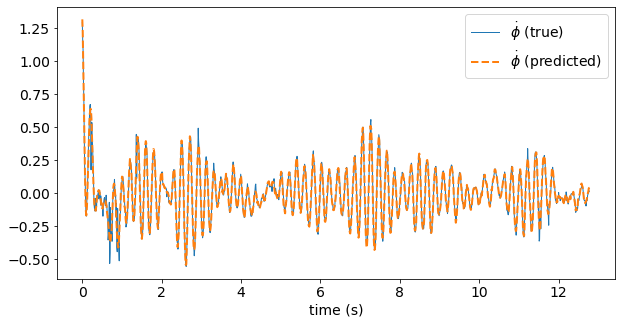

In [142]:
phi_dot_true = (phi[1:] - phi[:-1]) / dt

print(f'len(phi_dot_true) = {len(phi_dot_true)}')
print(f'         len(phi) = {len(phi)}')
print(f'           len(t) = {len(t)}')

phi_dot_predicted = w_x

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], phi_dot_true, label='$\dot{\phi}$ (true)', linewidth=1)
plt.plot(t, phi_dot_predicted, '--', label='$\dot{\phi}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

phi_dot_err = phi_dot_predicted[:-1] - phi_dot_true

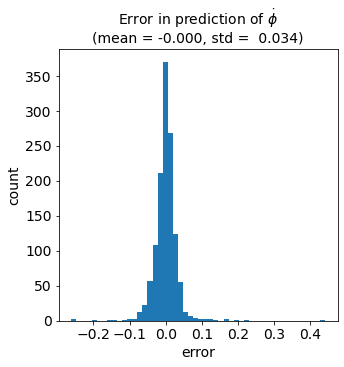

In [143]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(phi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

phi_std = np.std(phi_dot_err)

plt.title(
    'Error in prediction of $\dot{\phi}$\n' +
    f'(mean = {np.mean(phi_dot_err):6.3f}, std = {phi_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.7 Error in linear model of $\dot{v}_x$

len(v_x_dot_true) = 1278
         len(v_x) = 1279
           len(t) = 1279


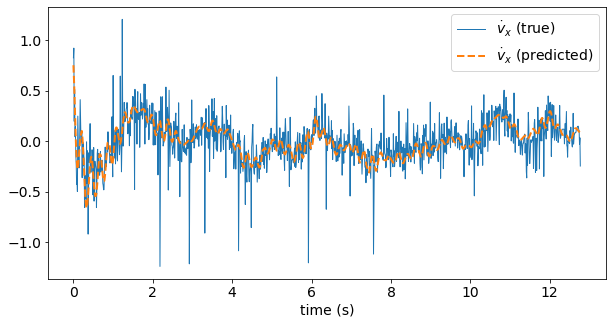

In [144]:
v_x_dot_true = (v_x[1:] - v_x[:-1]) / dt

print(f'len(v_x_dot_true) = {len(v_x_dot_true)}')
print(f'         len(v_x) = {len(v_x)}')
print(f'           len(t) = {len(t)}')

v_x_dot_predicted = g_val*theta

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_x_dot_true, label='$\dot{v}_x$ (true)', linewidth=1)
plt.plot(t, v_x_dot_predicted, '--', label='$\dot{v}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

v_x_dot_err = v_x_dot_predicted[:-1] - v_x_dot_true

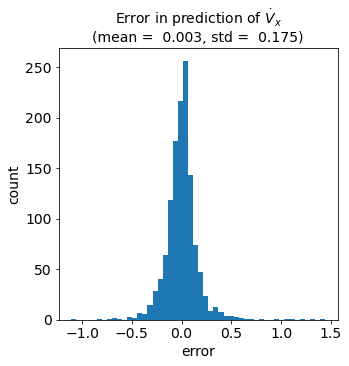

In [145]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(v_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

v_x_std = np.std(v_x_dot_err)

plt.title(
    'Error in prediction of $\dot{V}_x$\n' +
    f'(mean = {np.mean(v_x_dot_err):6.3f}, std = {v_x_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.8 Error in linear model of $\dot{v}_y$

len(v_y_dot_true) = 1278
         len(v_y) = 1279
           len(t) = 1279


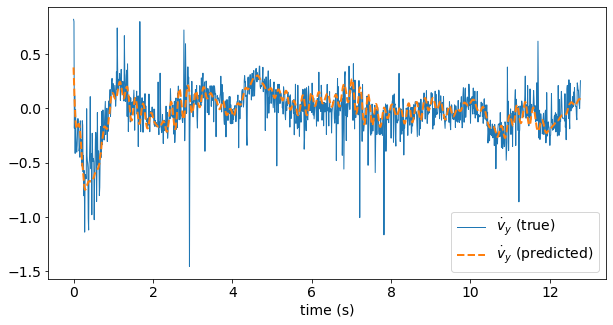

In [146]:
v_y_dot_true = (v_y[1:] - v_y[:-1]) / dt

print(f'len(v_y_dot_true) = {len(v_y_dot_true)}')
print(f'         len(v_y) = {len(v_y)}')
print(f'           len(t) = {len(t)}')

v_y_dot_predicted = -g_val*phi

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_y_dot_true, label='$\dot{v}_y$ (true)', linewidth=1)
plt.plot(t, v_y_dot_predicted, '--', label='$\dot{v}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

v_y_dot_err = v_y_dot_predicted[:-1] - v_y_dot_true

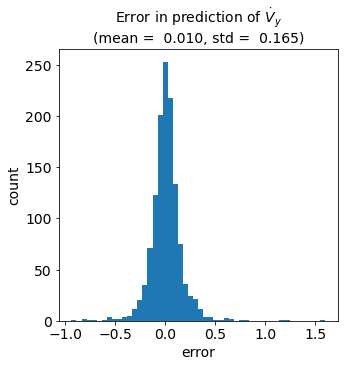

In [147]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(v_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

v_y_std = np.std(v_y_dot_err)

plt.title(
    'Error in prediction of $\dot{V}_y$\n' +
    f'(mean = {np.mean(v_y_dot_err):6.3f}, std = {v_y_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.2.9 Error in linear model of $\dot{v}_z$

len(v_z_dot_true) = 1278
         len(v_z) = 1279
           len(t) = 1279


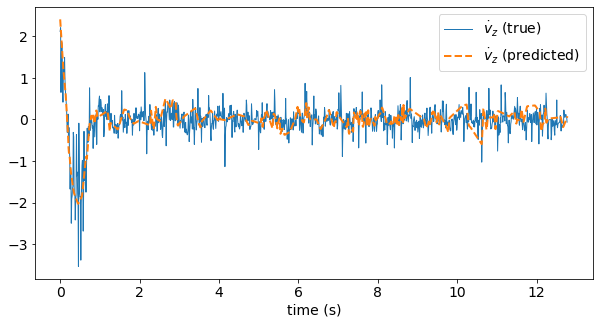

In [148]:
v_z_dot_true = (v_z[1:] - v_z[:-1]) / dt

print(f'len(v_z_dot_true) = {len(v_z_dot_true)}')
print(f'         len(v_z) = {len(v_z)}')
print(f'           len(t) = {len(t)}')

v_z_dot_predicted = a_z - g_val

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_z_dot_true, label='$\dot{v}_z$ (true)', linewidth=1)
plt.plot(t, v_z_dot_predicted, '--', label='$\dot{v}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

v_z_dot_err = v_z_dot_predicted[:-1] - v_z_dot_true

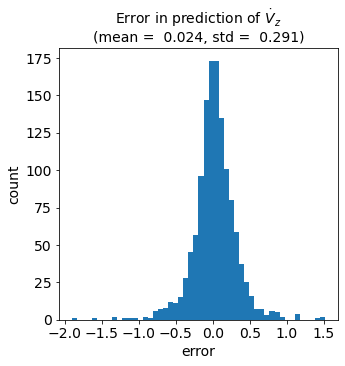

In [149]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(v_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

v_z_std = np.std(v_z_dot_err)

plt.title(
    'Error in prediction of $\dot{V}_z$\n' +
    f'(mean = {np.mean(v_z_dot_err):6.3f}, std = {v_z_std:6.3f})',
    fontsize=14,
)
plt.show()

## 4.3 Error in linearized measurement equations

### 4.3.1 Error in linear model of $n_x$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [150]:
n_x_predicted = k_flow_val * ((v_x / o_z_eq_val) - w_y)

Compare the true value and the predicted values of $n_x$ in a plot.

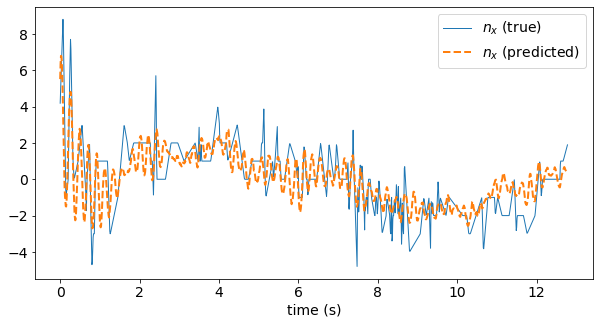

In [151]:
plt.figure(figsize=(10, 5))
plt.plot(t, n_x, label='$n_x$ (true)', linewidth=1)
plt.plot(t, n_x_predicted, '--', label='$n_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [152]:
n_x_err = n_x_predicted - n_x

Plot a histogram of the error, showing mean and standard deviation.

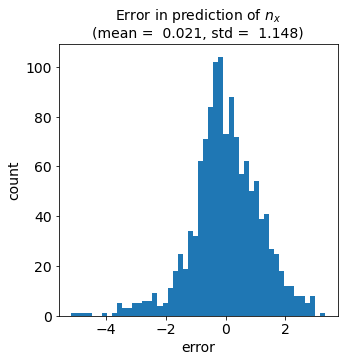

In [153]:
plt.figure(figsize=(5, 5))
plt.hist(n_x_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

n_x_std = np.std(n_x_err)

plt.title(
    'Error in prediction of $n_x$\n' +
    f'(mean = {np.mean(n_x_err):6.3f}, std = {n_x_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.2 Error in linear model of $n_y$

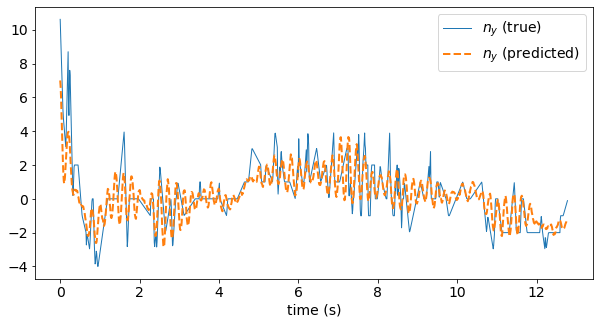

In [154]:
n_y_predicted = k_flow_val * ((v_y / o_z_eq_val) + w_x)

plt.figure(figsize=(10, 5))
plt.plot(t, n_y, label='$n_y$ (true)', linewidth=1)
plt.plot(t, n_y_predicted, '--', label='$n_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

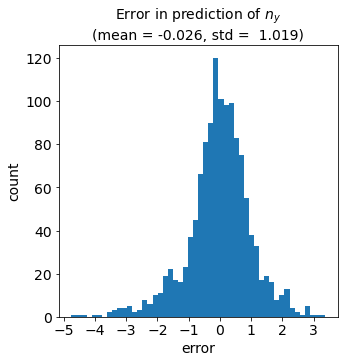

In [155]:
n_y_err = n_y_predicted - n_y

plt.figure(figsize=(5, 5))
plt.hist(n_y_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

n_y_std = np.std(n_y_err)

plt.title(
    'Error in prediction of $n_y$\n' +
    f'(mean = {np.mean(n_y_err):6.3f}, std = {n_y_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.3 Error in linear model of $r$

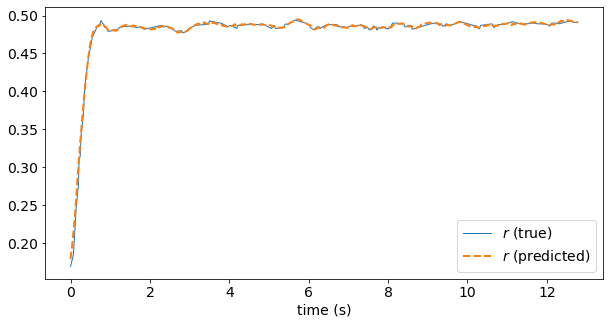

In [156]:
r_predicted = o_z

plt.figure(figsize=(10, 5))
plt.plot(t, r, label='$r$ (true)', linewidth=1)
plt.plot(t, r_predicted, '--', label='$r$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

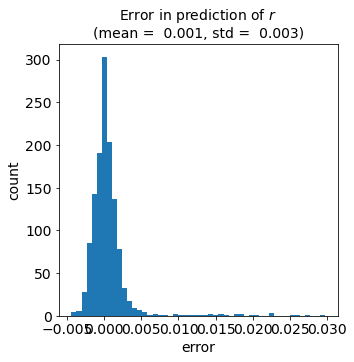

In [157]:
r_err = r_predicted - r

plt.figure(figsize=(5, 5))
plt.hist(r_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

r_std = np.std(r_err)

plt.title(
    'Error in prediction of $r$\n' +
    f'(mean = {np.mean(r_err):6.3f}, std = {r_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_0$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [158]:
d_0_predicted = ((o_x - x0_val)**2 + (o_y - y0_val)**2 + (o_z - z0_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

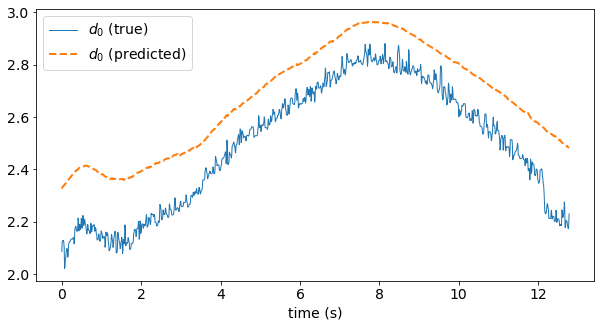

In [159]:
plt.figure(figsize=(10, 5))
plt.plot(t, d0, label='$d_0$ (true)', linewidth=1)
plt.plot(t, d_0_predicted, '--', label='$d_0$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [160]:
d_0_err = d_0_predicted - d0

Plot a histogram of the error, showing mean and standard deviation.

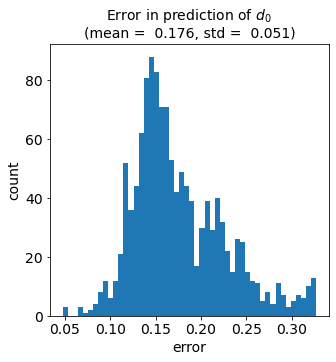

In [161]:
plt.figure(figsize=(5, 5))
plt.hist(d_0_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d0_std = np.std(d_0_err)

plt.title(
    'Error in prediction of $d_0$\n' +
    f'(mean = {np.mean(d_0_err):6.3f}, std = {d0_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_1$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [162]:
d_1_predicted = ((o_x - x1_val)**2 + (o_y - y1_val)**2 + (o_z - z1_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

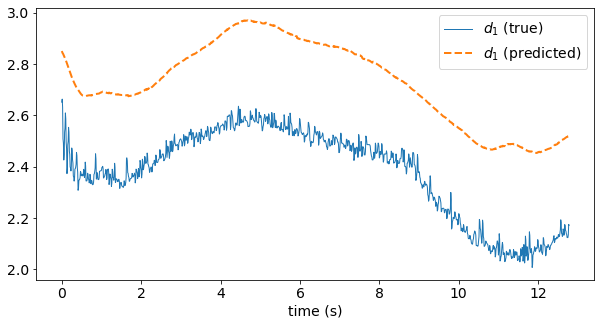

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(t, d1, label='$d_1$ (true)', linewidth=1)
plt.plot(t, d_1_predicted, '--', label='$d_1$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [164]:
d_1_err = d_1_predicted - d1

Plot a histogram of the error, showing mean and standard deviation.

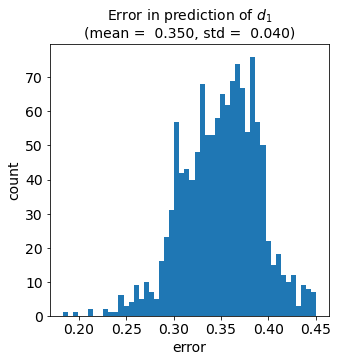

In [165]:
plt.figure(figsize=(5, 5))
plt.hist(d_1_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d1_std = np.std(d_1_err)

plt.title(
    'Error in prediction of $d_1$\n' +
    f'(mean = {np.mean(d_1_err):6.3f}, std = {d1_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_2$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [166]:
d_2_predicted = ((o_x - x2_val)**2 + (o_y - y2_val)**2 + (o_z - z2_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

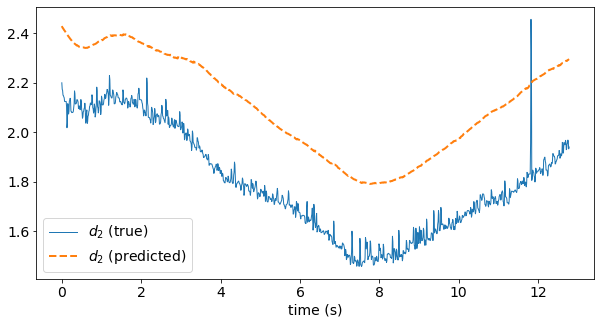

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(t, d2, label='$d_2$ (true)', linewidth=1)
plt.plot(t, d_2_predicted, '--', label='$d_2$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [168]:
d_2_err = d_2_predicted - d2

Plot a histogram of the error, showing mean and standard deviation.

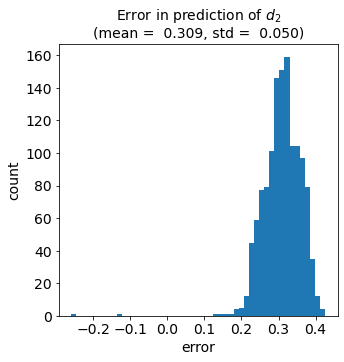

In [169]:
plt.figure(figsize=(5, 5))
plt.hist(d_2_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d2_std = np.std(d_2_err)

plt.title(
    'Error in prediction of $d_2$\n' +
    f'(mean = {np.mean(d_2_err):6.3f}, std = {d2_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_3$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [170]:
d_3_predicted = ((o_x - x3_val)**2 + (o_y - y3_val)**2 + (o_z - z3_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

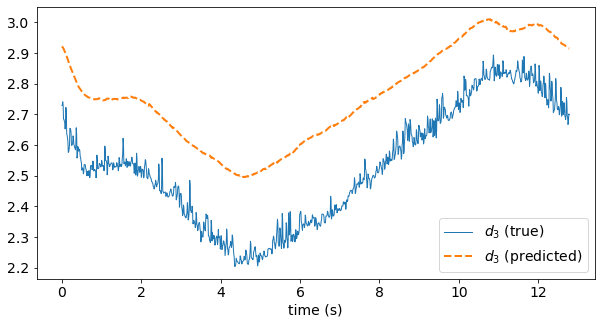

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(t, d3, label='$d_3$ (true)', linewidth=1)
plt.plot(t, d_3_predicted, '--', label='$d_3$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [172]:
d_3_err = d_3_predicted - d3

Plot a histogram of the error, showing mean and standard deviation.

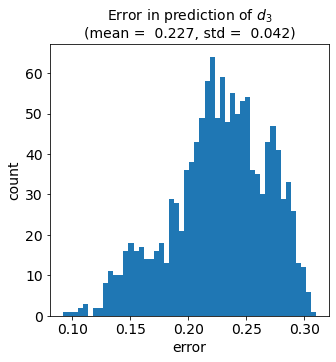

In [173]:
plt.figure(figsize=(5, 5))
plt.hist(d_3_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d3_std = np.std(d_3_err)

plt.title(
    'Error in prediction of $d_3$\n' +
    f'(mean = {np.mean(d_3_err):6.3f}, std = {d3_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_4$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [174]:
d_4_predicted = ((o_x - x4_val)**2 + (o_y - y4_val)**2 + (o_z - z4_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

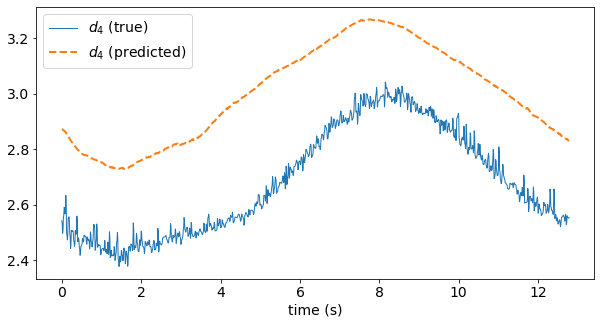

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(t, d4, label='$d_4$ (true)', linewidth=1)
plt.plot(t, d_4_predicted, '--', label='$d_4$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [176]:
d_4_err = d_4_predicted - d4

Plot a histogram of the error, showing mean and standard deviation.

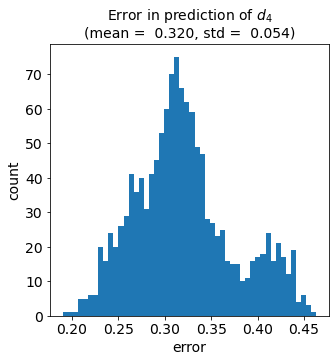

In [177]:
plt.figure(figsize=(5, 5))
plt.hist(d_4_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d4_std = np.std(d_4_err)

plt.title(
    'Error in prediction of $d_4$\n' +
    f'(mean = {np.mean(d_4_err):6.3f}, std = {d4_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_5$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [178]:
d_5_predicted = ((o_x - x5_val)**2 + (o_y - y5_val)**2 + (o_z - z5_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

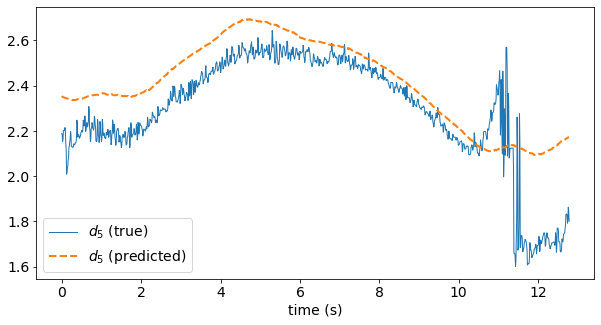

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(t, d5, label='$d_5$ (true)', linewidth=1)
plt.plot(t, d_5_predicted, '--', label='$d_5$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [180]:
d_5_err = d_5_predicted - d5

Plot a histogram of the error, showing mean and standard deviation.

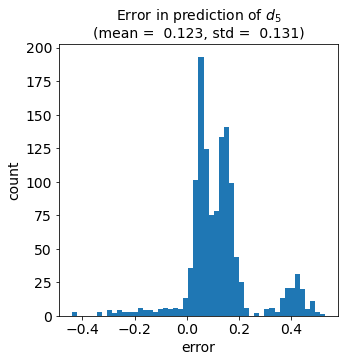

In [181]:
plt.figure(figsize=(5, 5))
plt.hist(d_5_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d5_std = np.std(d_5_err)

plt.title(
    'Error in prediction of $d_5$\n' +
    f'(mean = {np.mean(d_5_err):6.3f}, std = {d5_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_0$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [182]:
d_6_predicted = ((o_x - x6_val)**2 + (o_y - y6_val)**2 + (o_z - z6_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

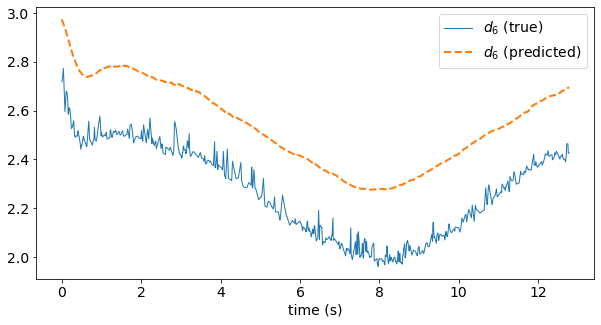

In [183]:
plt.figure(figsize=(10, 5))
plt.plot(t, d6, label='$d_6$ (true)', linewidth=1)
plt.plot(t, d_6_predicted, '--', label='$d_6$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [184]:
d_6_err = d_6_predicted - d6

Plot a histogram of the error, showing mean and standard deviation.

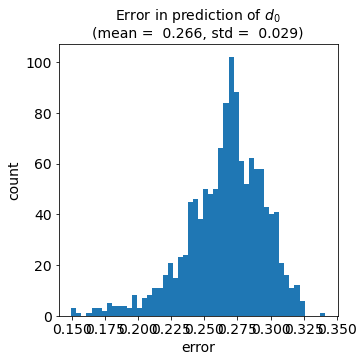

In [185]:
plt.figure(figsize=(5, 5))
plt.hist(d_6_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d6_std = np.std(d_6_err)

plt.title(
    'Error in prediction of $d_0$\n' +
    f'(mean = {np.mean(d_6_err):6.3f}, std = {d6_std:6.3f})',
    fontsize=14,
)
plt.show()

### 4.3.1 Error in linear model of $d_7$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [186]:
d_7_predicted = ((o_x - x7_val)**2 + (o_y - y7_val)**2 + (o_z - z7_val)**2)**(1/2)
    

Compare the true value and the predicted values of $n_x$ in a plot.

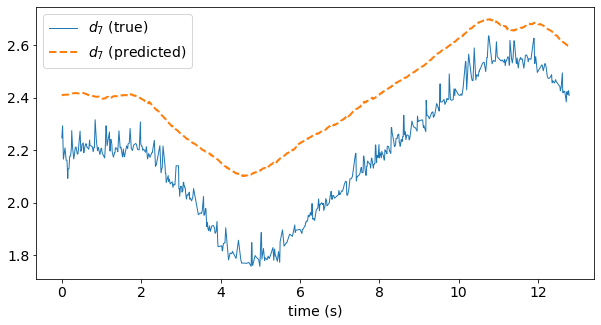

In [187]:
plt.figure(figsize=(10, 5))
plt.plot(t, d7, label='$d_7$ (true)', linewidth=1)
plt.plot(t, d_7_predicted, '--', label='$d_7$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [188]:
d_7_err = d_7_predicted - d7

Plot a histogram of the error, showing mean and standard deviation.

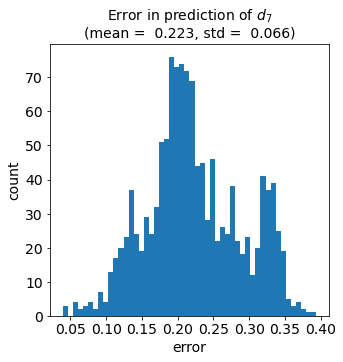

In [189]:
plt.figure(figsize=(5, 5))
plt.hist(d_7_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d7_std = np.std(d_7_err)

plt.title(
    'Error in prediction of $d_7$\n' +
    f'(mean = {np.mean(d_7_err):6.3f}, std = {d7_std:6.3f})',
    fontsize=14,
)
plt.show()

## 4.4 Summary

In [190]:
print(f'o_x STD: {o_x_std}')
print(f'o_y STD: {o_y_std}')
print(f'o_z STD: {o_z_std}')
print(f'psi STD: {psi_std}')
print(f'theta STD: {theta_std}')
print(f'phi STD: {phi_std}')
print(f'v_x STD: {v_x_std}')
print(f'v_y STD: {v_y_std}')
print(f'v_z STD: {v_z_std}')
print(f'n_x STD: {n_x_std}')
print(f'n_y STD: {n_y_std}')
print(f'r STD: {r_std}')
print(f'd0 STD: {d0_std}')
print(f'd1 STD: {d1_std}')
print(f'd2 STD: {d2_std}')
print(f'd3 STD: {d3_std}')
print(f'd4 STD: {d4_std}')
print(f'd5 STD: {d5_std}')
print(f'd6 STD: {d6_std}')
print(f'd7 STD: {d7_std}')

o_x STD: 0.09305422076419373
o_y STD: 0.0890552408345728
o_z STD: 0.03444545891175363
psi STD: 0.018380172956412685
theta STD: 0.03949526772108016
phi STD: 0.033966011132145264
v_x STD: 0.17519980908938718
v_y STD: 0.16474259344780914
v_z STD: 0.2913121449243173
n_x STD: 1.1483227836606125
n_y STD: 1.0185635634670225
r STD: 0.003009881173418026
d0 STD: 0.051058908636410466
d1 STD: 0.03994815488522957
d2 STD: 0.049892221599747336
d3 STD: 0.04159349453845495
d4 STD: 0.053572920451368786
d5 STD: 0.1308392136466866
d6 STD: 0.029241473042742477
d7 STD: 0.06629177955217079


The following table reports the mean and standard deviation of error in the linearized equations of motion:

|  | $\dot{o}_x$ | $\dot{o}_y$ | $\dot{o}_z$ | $\dot{\psi}$ | $\dot{\theta}$ | $\dot{\phi}$ | $\dot{v}_x$ | $\dot{v}_y$ | $\dot{v}_z$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| mean | 0.003 | -0.004 | 0.001 | 0.001 | 0.000 | 0.001 | 0.004 | -0.008 | 0.008 |
| std | 0.118 | 0.071 | 0.030 | 0.008 | 0.043 | 0.033 | 0.0233 | 0.143 | 0.171 |

The following table reports the mean and standard deviation of error in the linearized measurement equations:

|  | $n_x$ | $n_y$ | $r$ |
| :--: | :--: | :--: | :--: |
| mean | -0.019 | -0.131 | 0.001 |
| std | 1.104 | 0.905 | 0.003 |

# 5. L, Q, and R

In [191]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

In [208]:
W_o = obsv(A_obs, C_obs)

print(W_o)

print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  8.18511136e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  8.18511136e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.81895674e-01  7.27355386e-01  7.72815098e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.42352700e-01 -6.65784693e-01 -5.12429792e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.15428025e-01 -6.95880811e-01  6.25510841e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.45635635e-01  5.76719472e-01 -5.00548976e-01  0.00000000e+00
   0.00000000e+00  0.0000000

In [207]:
A_obs = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 981/100, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, -981/100, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

B_obs = np.array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

C_obs = np.array([[0, 0, 0, 0, 0, 0, 102313891987647/12500000000000, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 102313891987647/12500000000000, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0.681895674366232, 0.727355385990648, 0.0772815097615063, 0, 0,
        0, 0, 0, 0],
       [0.542352699501114, -0.665784693180678, -0.512429791942432, 0, 0,
        0, 0, 0, 0],
       [-0.715428024827035, -0.695880811033947, 0.0625510841378828, 0, 0,
        0, 0, 0, 0],
       [-0.645635635303831, 0.576719471984883, -0.500548975684993, 0, 0,
        0, 0, 0, 0],
       [0.588118863136118, 0.607464878370859, -0.533950020478844, 0, 0,
        0, 0, 0, 0],
       [0.645588044517566, -0.760264868214765, 0.0722039260315698, 0, 0,
        0, 0, 0, 0],
       [-0.640519895012334, -0.613117974370095, -0.462407410837781, 0, 0,
        0, 0, 0, 0],
       [-0.751008902140546, 0.656101183738170, 0.0742756057062079, 0, 0,
        0, 0, 0, 0]])

D_obs = np.array([[0, -102313891987647/25000000000000, 0, 0],
       [102313891987647/25000000000000, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

Q = np.diag([
    (1/n_x_std)**2,   # n_x
    (1/n_y_std)**2,   # n_y
    (1/r_std)**2,     # r
    (1/d0_std)**2,    # d0
    (1/d1_std)**2,    # d1
    (1/d2_std)**2,    # d2
    (1/d3_std)**2,    # d3
    (1/d4_std)**2,    # d4
    (1/d5_std)**2,    # d5
    (1/d6_std)**2,    # d6
    (1/d7_std)**2,    # d7
])

R = np.diag([
    (1/o_x_std)**2,   # o_x
    (1/o_y_std)**2,   # o_y
    (1/o_z_std)**2,   # o_z
    (1/psi_std)**2,   # psi
    (1/theta_std)**2, # theta
    (1/phi_std)**2,   # phi
    (1/v_x_std)**2,   # v_x
    (1/v_y_std)**2,   # v_y
    (1/v_z_std)**2,   # v_z
])

L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

LinAlgError: Failed to find a finite solution.